In [1]:
!ls -ldh ../../../weather_data/stations_weather_with_dist2coast.parquet/part.0.parquet

-rw-rw-r-- 1 yfreund yfreund 34M Oct 24 23:42 ../../../weather_data/stations_weather_with_dist2coast.parquet/part.0.parquet


In [2]:

import dask.dataframe as dd

# The joined weather data with station info and distance from coast is assumed to be in:
file_path = "../../../weather_data/stations_weather_with_dist2coast.parquet"
df = dd.read_parquet(file_path)


In [3]:

print([col for col in df.columns if not col.startswith('day_')])

['station_id_x', 'latitude', 'longitude', 'elevation', 'state', 'name', 'gsn_flag', 'hcn_crn_flag', 'wmo_id', 'ID', 'year', 'ELEMENT', 'station_id_y', 'dist_to_coast']


In [4]:
import matplotlib.pyplot as plt

# Select rows where ELEMENT is 'SNWD'
snwd_df = df[df['ELEMENT'] == 'SNWD']

# Identify all day columns (assuming they start with 'day_' and go from day_1 to day_365)
day_cols = [col for col in snwd_df.columns if col.startswith('day_')]

# Compute the mean SNWD value across all day columns for each row (station-year), treating NaNs as zeros
snwd_df['mean_snwd'] = snwd_df[day_cols].fillna(0).mean(axis=1)

# Drop any rows with NaN mean values (if desired)
mean_snwd = snwd_df['mean_snwd'].compute().dropna()


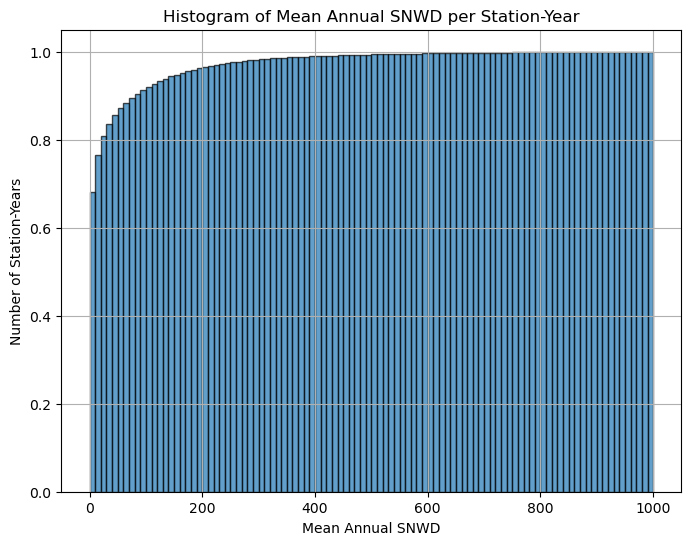

In [5]:

# Plot histogram of mean SNWD values
plt.figure(figsize=(8, 6))
plt.hist(mean_snwd, bins=100, range=(0, 1000), edgecolor='k', alpha=0.7, cumulative=True, density=True)
plt.grid()
plt.xlabel('Mean Annual SNWD')
plt.ylabel('Number of Station-Years')
plt.title('Histogram of Mean Annual SNWD per Station-Year')
plt.show()


In [6]:
num_zero_means = (mean_snwd <10).sum()
total_means = mean_snwd.shape[0]
frac_zero_means = num_zero_means / total_means
print(f"Number of mean SNWD values equal to zero: {num_zero_means}")
print(f"Fraction of mean SNWD values equal to zero: {frac_zero_means:.4f}")


Number of mean SNWD values equal to zero: 690719
Fraction of mean SNWD values equal to zero: 0.6803


In [7]:
import numpy as np
np.mean(mean_snwd), np.std(mean_snwd)

(32.16144225957513, 100.20120130462004)

In [10]:

# Show number of SNWD rows before and after removing rows where mean (nan->0) < 10
num_rows_before = df.shape[0].compute() if hasattr(df.shape[0], 'compute') else df.shape[0]
print(f"Total number of rows in df before removal: {num_rows_before}")

# Get SNWD rows and number before
snwd_mask = (df['ELEMENT'] == 'SNWD')
snwd_rows = df[snwd_mask].copy()
num_snwd_before = snwd_rows.shape[0].compute() if hasattr(snwd_rows.shape[0], 'compute') else snwd_rows.shape[0]
print(f"Number of SNWD rows before removal: {num_snwd_before}")

# Identify day columns and compute mean with nan->0 for SNWD rows
day_cols = [col for col in snwd_rows.columns if col.startswith('day_')]
snwd_rows['mean_snwd'] = snwd_rows[day_cols].fillna(0).mean(axis=1)

# Find SNWD rows to keep (mean >= 10)
snwd_rows_to_keep = snwd_rows[snwd_rows['mean_snwd'] >= 10]
num_snwd_after = snwd_rows_to_keep.shape[0].compute() if hasattr(snwd_rows_to_keep.shape[0], 'compute') else snwd_rows_to_keep.shape[0]

print(f"Number of SNWD rows after removal: {num_snwd_after}")
print(f"SNWD rows removed: {num_snwd_before - num_snwd_after}")
print(f"SNWD percentage removed: {((num_snwd_before - num_snwd_after) / num_snwd_before * 100):.2f}%")

# Now filter the main dataframe: keep non-SNWD rows + SNWD rows with mean >= 10
non_snwd_rows = df[df['ELEMENT'] != 'SNWD']
df = dd.concat([non_snwd_rows, snwd_rows_to_keep.drop('mean_snwd', axis=1)])

num_rows_after = df.shape[0].compute() if hasattr(df.shape[0], 'compute') else df.shape[0]
print(f"Total number of rows in df after removal: {num_rows_after}")
print(f"Total rows removed: {num_rows_before - num_rows_after}")



Total number of rows in df before removal: 7415065
Number of SNWD rows before removal: 1015287
Number of SNWD rows after removal: 324568
SNWD rows removed: 690719
SNWD percentage removed: 68.03%
Total number of rows in df after removal: 6724346
Total rows removed: 690719


In [ ]:
df.to_parquet("../../../weather_data/processed_weather.parquet")


: 